In [57]:
# SOFTMAX = False
# EPSILON = True
# COUNT = False

# SOFTMAX = True
# EPSILON = False
# COUNT = False

# SOFTMAX = False
# EPSILON = True
# COUNT = True

SOFTMAX = True
EPSILON = False
COUNT = True

# Imports

In [58]:
%matplotlib inline
import gym
from gym.envs.toy_text.frozen_lake import MAPS
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as T    
import cv2
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import warnings
warnings.filterwarnings('ignore')

# Set up display

In [59]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

# Deep Q-Network

In [60]:
class DQN(nn.Module):
    def __init__(self, input_channels, num_actions):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels,32,5)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32,16,5)
        self.bn2 = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(16*13*13, 30)
        self.fc2 = nn.Linear(30, 10)
        self.fc3 = nn.Linear(10, num_actions)
        
        # self.fc1 = nn.Linear(in_features=map_height*map_width*3, out_features=16)   
        # self.fc2 = nn.Linear(in_features=16, out_features=32)
        # self.out = nn.Linear(in_features=32, out_features=num_actions)

    def forward(self, t):
        # t = t.flatten(start_dim=1)
        # t = F.relu(self.fc1(t))
        # t = F.relu(self.fc2(t))
        # t = self.out(t)

        t = self.pool(self.bn1(F.relu(self.conv1(t))))
        t = self.pool2(self.bn2(F.relu(self.conv2(t))))
#         print(t.shape)
        t = t.view(-1,16*13*13)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.fc3(t)

        return t

# Experience class

In [61]:
Experience = namedtuple('Experience',('state', 'action', 'next_state', 'reward','terminated'))

# Replay Memory class

In [62]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        self.state_counter_dic = {}
      
    def push(self, experience):
        if (em.env.s not in self.state_counter_dic):
            self.state_counter_dic[em.env.s] = 1
        else:
             self.state_counter_dic[em.env.s] = self.state_counter_dic[em.env.s]+1

        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
      
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size
    
    def state_counter(self, state):
        """
        Return the number of times that state has been seen
        :state: The state that we are looking for how many times it has been seen
        """
        counter = 0
        for experience in self.memory:
            if torch.all(torch.eq(experience[0][0], state)):
                counter += 1  
        return counter      

# Epsilon Greedy Strategy

In [63]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

# Agent

In [64]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
        
    def select_action(self, state, policy_net):
        def softmax(x):
            """Compute softmax values for each sets of scores in x."""
            e_x = np.exp(x - np.max(x))
            return e_x / e_x.sum(axis=0)
        
        if(SOFTMAX):        
            actions = policy_net(state).cpu().detach().numpy().squeeze()
            prob = softmax(actions)
            action = np.random.choice(list(actions), 1,p=prob)
            action = np.where(actions==action)[0][0]
            return torch.tensor([action]).to(device)

        #return torch.tensor(policy_net(state).argmax(dim=1).to(self.device)).to(self.device) # exploit

        if(EPSILON):
            rate = self.strategy.get_exploration_rate(self.current_step)
            self.current_step += 1
            if rate > random.random():
                action = random.randrange(self.num_actions)
                return torch.tensor([action]).to(device) # explore      
            else:
                with torch.no_grad():
                    return torch.tensor(policy_net(state).argmax(dim=1).to(self.device) ).to(self.device) # exploit
            

# Environment Manager 

In [65]:
class FrozenLakeEnvManager():
    def __init__(self, device, map_joan, map_frozen_lake):
        """
        :param map_joan: The original map with no agent
        :param map_frozen_lake: The map for gym
        """
        self.device = device
        self.env = gym.make('FrozenLake-v0',desc=map_frozen_lake, is_slippery=False).unwrapped
        self.done = False
        #0 = goal; 1 = hole ; 2 = agent;3 = ice
        self.original_map = map_joan             
        self.map_status = []
        self.reset()
        self.image_side = 64
    
    def reset(self):
        self.env.reset()
        self.done = False
        self.map_status = self.original_map.copy()
        self.map_status[0] = 2
        
    def close(self):
        self.env.close()

    def render(self, mode='char'):
        if mode == 'human':
            return self.env.render(mode)
        if mode == 'char':
            for i in range(0,len(self.original_map)):
                if(i%(np.sqrt(len(self.original_map)))==0):
                    print('')

                if(self.map_status[i]==2):
                    print(".",end="")
                else:
                    print(self.map_status[i],end="")
            print()
            #return self.env.render('human')
        elif mode == 'image':
            tensor_image_state = char_map_to_tensor(self.map_status,self.image_side)
            display_tensor(tensor_image_state)
            if is_ipython: display.clear_output(wait=True)
        elif mode == 'image_gray':
            tensor_image_state = char_map_to_tensor_gray(self.map_status,self.image_side)
            display_tensor_gray(tensor_image_state)
            if is_ipython: display.clear_output(wait=True)
        
                 
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action, memory):
        prev_state = self.env.s        
        new_state, reward, self.done, info = self.env.step(action.item())
        self.map_status = self.original_map.copy()
        self.map_status[new_state] = 2        
        
        #newer is the state bigger is the reward
        #reward = 1 * np.exp(-memory.state_counter(self.get_state()))
        #reward = 1/np.sqrt((memory.state_counter(self.get_state())+0.01))        
        # reward = 1/((5*memory.state_counter(self.get_state())+0.1))
        # reward = 1 / ( np.exp(memory.state_counter(self.get_state())*memory.state_counter(self.get_state())) )
        reward = 0
        if (COUNT):
            if (new_state not in memory.state_counter_dic):
                reward = 1
            else:
                reward = 1/(np.sqrt((memory.state_counter_dic[new_state]))+1)


        if (self.original_map[new_state]==0):
            #GOAL
            #print("DIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIING")  
            reward += 10
            #input()
        elif (self.original_map[new_state]==1 or prev_state == self.env.s):
            #HOLE
            reward = -1
            self.done = True
        elif (self.original_map[new_state]==3):
            #ICE
            reward += 0 


        return torch.tensor([reward], dtype=torch.float,device=self.device)
    
    def get_state(self):
        tensor_image_state = char_map_to_tensor_gray(self.map_status,self.image_side)
        state = torch.tensor(tensor_image_state).to(self.device).unsqueeze(0).unsqueeze(0).float()
        return state
    

# Utility

In [66]:
def create_q_values_to_display():
    grid_side = np.sqrt(len(em.original_map))
    for i in range(len(em.original_map)):
        #Put the agent in each position
        map = em.original_map.copy()
        is_Ice = True if map[i]==3 else False
        is_Hole = True if map[i]==1 else False
        is_Goal = True if map[i]==0 else False        
        is_Start = True if i==0 else False

        map [i] = 2    
        tensor_map = char_map_to_tensor(map, em.image_side)

        tensor_cuda = tensor_map.unsqueeze(0).cuda().float()

        q = []
        policy_net.eval()
        with torch.no_grad():
            for value in policy_net(tensor_cuda)[0].tolist():
                q.append(round(value,3))
        policy_net.train()

        if (is_Ice):
            if (is_Start):
                q_value = np.array([[np.NaN, q[3], np.NaN], 
                                    [q[0], 0, q[2]], 
                                    [np.NaN, q[1], np.NaN]])
            else:
                q_value = np.array([[np.NaN, q[3], np.NaN], 
                                    [q[0], np.NaN, q[2]], 
                                    [np.NaN, q[1], np.NaN]])
        elif (is_Hole):
            q_value = np.array([[np.NaN, np.NaN, np.NaN], 
                                [np.NaN, np.NaN, np.NaN], 
                                [np.NaN, np.NaN, np.NaN]])
        elif (is_Goal):
            q_value = np.array([[np.NaN, np.NaN, np.NaN], 
                                [np.NaN, 10, np.NaN], 
                                [np.NaN, np.NaN, np.NaN]])  
            
        if (i == 0):
            prev_q_values = q_value
        else:
            prev_q_values = np.concatenate((prev_q_values, q_value), axis=1)

        
    q_values_display = np.split(prev_q_values,grid_side,axis=1)[0]

    for cell in np.split(prev_q_values,grid_side,axis=1)[1:] :
        q_values_display = np.concatenate((q_values_display,cell),axis=0)
    
    return q_values_display

In [67]:
def create_q_values_to_display_gray():
    grid_side = np.sqrt(len(em.original_map))
    for i in range(len(em.original_map)):
        #Put the agent in each position
        map = em.original_map.copy()
        is_Ice = True if map[i]==3 else False
        is_Hole = True if map[i]==1 else False
        is_Goal = True if map[i]==0 else False        
        is_Start = True if i==0 else False

        map [i] = 2    
        tensor_map = char_map_to_tensor_gray(map, em.image_side).unsqueeze(0).unsqueeze(0).cuda().float()
        
        q = []
        policy_net.eval()
        with torch.no_grad():
            for value in policy_net(tensor_map)[0].tolist():
                q.append(round(value,3))
        policy_net.train()

        if (is_Ice):
            if (is_Start):
                q_value = np.array([[np.NaN, q[3], np.NaN], 
                                    [q[0], 0, q[2]], 
                                    [np.NaN, q[1], np.NaN]])
            else:
                q_value = np.array([[np.NaN, q[3], np.NaN], 
                                    [q[0], np.NaN, q[2]], 
                                    [np.NaN, q[1], np.NaN]])
        elif (is_Hole):
            q_value = np.array([[np.NaN, np.NaN, np.NaN], 
                                [np.NaN, np.NaN, np.NaN], 
                                [np.NaN, np.NaN, np.NaN]])
        elif (is_Goal):
            q_value = np.array([[np.NaN, np.NaN, np.NaN], 
                                [np.NaN, 10, np.NaN], 
                                [np.NaN, np.NaN, np.NaN]])  
            
        if (i == 0):
            prev_q_values = q_value
        else:
            prev_q_values = np.concatenate((prev_q_values, q_value), axis=1)

        
    q_values_display = np.split(prev_q_values,grid_side,axis=1)[0]

    for cell in np.split(prev_q_values,grid_side,axis=1)[1:] :
        q_values_display = np.concatenate((q_values_display,cell),axis=0)
    
    return q_values_display

In [68]:
def display_q_values():
    #data = create_q_values_to_display()
    data = create_q_values_to_display_gray()
    grid_side = np.sqrt(len(em.original_map))

    fig, ax = plt.subplots(figsize=(20, 10))
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    ax.matshow(data)

    for (i, j), z in np.ndenumerate(data):
        if(not np.isnan(z)):
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
            # ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            #         bbox=dict(boxstyle='circle', facecolor='white', edgecolor='0.1'))

    ax.set_yticks(np.arange(-0.5, 3*grid_side-0.5, 3), minor=False)
    ax.set_xticks(np.arange(-0.5, 3*grid_side-0.5, 3), minor=False)

    plt.grid(color='r',linewidth=3)
    plt.show()

In [69]:
def char_map_to_tensor(char_map, resized_side):
    """
    Return an tensor representing the char_map as an image C x H x W
    :char_map: The map represented with characters i.e. [3,3,3,3,3,1,3,1,3,3,3,1,1,3,3,0]
    :resized_side: hight and width of the image
    """
    len_map_side = int(np.sqrt(len(char_map)))
    map_image = np.empty([len_map_side, len_map_side, 3])
    
    agent_color = [255, 0, 0] #RED
    ice_color = [0, 0, 255] #BLUE
    hole_color = [0, 0, 0] #BLACK
    goal_color = [0, 255, 0] #GREEN
    
    colors = [goal_color, hole_color, agent_color, ice_color]
    
    #0 = goal; 1 = hole; 2 = agent; 3 = ice
    for i, char in enumerate(char_map):
        #print(i//len_map_side,i%len_map_side)
        map_image[i//len_map_side,i%len_map_side] = colors[char] 


    map_image_resized = cv2.resize(map_image, dsize=(resized_side, resized_side),interpolation=cv2.INTER_NEAREST)
    
    #change H, W, C to C, H, W
    map_image_resized_c_h_w = np.transpose(map_image_resized,(2,0,1))

    map_tensor = torch.tensor(map_image_resized_c_h_w)
    return map_tensor  
    

In [70]:
def char_map_to_tensor_gray(char_map, resized_side):
    """
    Return an tensor representing the char_map as an image C x H x W
    :char_map: The map represented with characters i.e. [3,3,3,3,3,1,3,1,3,3,3,1,1,3,3,0]
    :resized_side: hight and width of the image
    """
    len_map_side = int(np.sqrt(len(char_map)))
    map_image = np.empty([len_map_side, len_map_side, 1])
       
    agent_color = 150 
    ice_color = 64
    hole_color = 0
    goal_color = 255
    
    colors = [goal_color, hole_color, agent_color, ice_color]
    
    #0 = goal; 1 = hole; 2 = agent; 3 = ice
    for i, char in enumerate(char_map):
        #print(i//len_map_side,i%len_map_side)
        map_image[i//len_map_side,i%len_map_side] = colors[char] 

    map_image_resized = cv2.resize(map_image, dsize=(resized_side, resized_side),interpolation=cv2.INTER_NEAREST)
    
    return torch.tensor(map_image_resized)
    

In [71]:
def display_tensor(t):
    """
    Display a tesnor which is an state of the frozen lake
    :t: The tensor of shape C x H x W
    """
    plt.imshow(np.uint8(t.permute(1,2,0)))

In [72]:
def display_tensor_gray(t):
    """
    Display a tesnor which is an state of the frozen lake
    :t: The tensor of shape H x W
    """
    plt.imshow(np.uint8(t),cmap='gray')

In [73]:
def plot(values, moving_avg_period, eps,episode_rewards_exploit):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(values)
    plt.plot(episode_rewards_exploit)

       
    moving_avg = get_moving_average(moving_avg_period, values)  
    if len(values) >= moving_avg_period:
        plt.plot(moving_avg)
    plt.pause(0.001)
        
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1], "\n", \
        "Epsilon:",eps, "\n"
        )
    

    if is_ipython: display.clear_output(wait=True)

In [74]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))

        moving_avg = moving_avg.numpy()

        moving_avg_with_nans = np.empty(len(moving_avg))
        moving_avg_with_nans[:] = np.nan
        moving_avg_with_nans[:]
        moving_avg_with_nans[period:] = moving_avg[period:]
        return moving_avg_with_nans
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [75]:
def generate_random_map(size=4, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] != 'H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)

    map_frozen_lake = ["".join(x) for x in res]
    map_joan = []
    for row in map_frozen_lake:
        for cell in row:
            if cell == 'S' or cell == 'F':
                map_joan.append(3)
            elif cell == 'H':
                map_joan.append(1)
            elif cell ==  'G':
                map_joan.append(0)
    return map_joan,map_frozen_lake


# Q-Value calcualtor

In [76]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    t5 = torch.cat(batch.terminated)

    return (t1,t2,t3,t4,t5)

In [77]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return torch.squeeze(policy_net(states.float()).gather(dim=1, index=actions.unsqueeze(-1)))
        
    
    @staticmethod        
    def get_next(target_net, next_states, terminated):

        index_not_terminated_states = []
        for i,c in enumerate(terminated):
          if(not c.item()):
            index_not_terminated_states.append(i)
        non_final_states = next_states[index_not_terminated_states] 
                           
        # final_state_locations = next_states.flatten(start_dim=1) \
        #     .max(dim=1)[0].eq(0).type(torch.bool)
        # non_final_state_locations = (final_state_locations == False)
        # non_final_states = next_states[non_final_state_locations]

        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        
        if(non_final_states.nelement() != 0):
            values[index_not_terminated_states] = target_net(non_final_states).max(dim=1)[0].detach()
            #values[index_not_terminated_states] = target_net(non_final_states).max(dim=1)[0].clone().detach().requires_grad_(True)
        
        
        # print(final_state_locations)
        # print(next_states)
        # print(non_final_states)
        # input()  

        return values

In [78]:
def exploit_episode(policy_net):
    policy_net.eval()

    em1 = FrozenLakeEnvManager(device, map_joan, map_frozen_lake)
    em1.reset()
    eps_reward = 0
    c = 0
    while(em1.done == False):
        prev_state = em1.env.s
        state = em1.get_state()        
        action = torch.tensor(policy_net(state).argmax(dim=1).to(device)).to(device)
        
        new_state, reward, em1.done, info = em1.env.step(action.item())
        em1.map_status = em1.original_map.copy()
        em1.map_status[new_state] = 2     
        
        if (em1.original_map[new_state]==0):
            #GOAL
            #print("DIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIING")  
            reward = 10
            #input()
        elif (em1.original_map[new_state]==1 or prev_state == em1.env.s):
            #HOLE
            reward = -1
            em1.done = True
        elif (em1.original_map[new_state]==3):
            #ICE
            reward = 0 
        
        eps_reward += reward
        next_state = em1.get_state()
        state = next_state
        if(c>len(em1.map_status)):
            break
        c=c+1
        
    policy_net.train()
    
    return eps_reward

    

# MAIN

In [79]:
#Hyperparameters
grid_size = 6
batch_size = 40
gamma = 0.95 #95
eps_start = 1
eps_end = 0.01
eps_decay = 0.001

target_update = 15 #5
memory_size = 200
lr = 11**-4
num_episodes = 300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

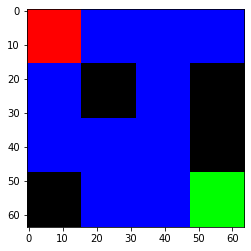

In [80]:
#4x4
map_joan, map_frozen_lake = [3,3,3,3,3,1,3,1,3,3,3,1,1,3,3,0],MAPS['4x4']

#6x6
#map_joan, map_frozen_lake = [3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 0],['SHHHFF', 'FFFHHF', 'HFFFHH', 'HFFHHH', 'HHFHHH', 'FHFFFG']

#8x8
#Test
#map_joan, map_frozen_lake = [3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 0],['SFHHHHHH', 'HFFFHHHH', 'HHHFFHHH', 'HHFHFFHH', 'HHHFHFFH', 'HFHFHFFF', 'HHHHFHHF', 'HHHHHHFG']
#map_joan, map_frozen_lake = [3, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 0],['SFHFHHFH', 'FHHHFHFH', 'FFFHHHHF', 'FFHHHFFH', 'FHFHFFFF', 'FFFFFFFF', 'FHHFHHHF', 'FFHFFFFG']
#map_joan, map_frozen_lake =[3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 0],['SFHFFFHH', 'FHHHHHHH', 'FFHHFFHH', 'FHFHHFHH', 'FFFFFFHH', 'HHHHFHFH', 'FHFFFFFH', 'HHFFFHFG']

#12x12
#map_joan, map_frozen_lake = [3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 0],['SFFHFHHFHFFH', 'HHFHHHFHHHFH', 'FHFFFHHHFFHH', 'HFFHFFHHHHFF', 'HHHHFHHFFHFF', 'FHFFFFFHHHFH', 'FHHHHFFHFFFH', 'HHFHHHFHFFHF', 'HFHHFFFFFFFF', 'FHFFHFHHFHHH', 'HFFHHFHHFFFF', 'FFHFHHHHHFHG']

#16x16
#map_joan, map_frozen_lake = [3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 0],['SFFFFFHHFHFHHFFH', 'HFFHFHHHHFFHHHHH', 'FHFFFFFFFHFHFHFF', 'FFHHFFFFFHFFHHHH', 'FFFHHFFFHHFHHFHH', 'HFHFFFFHFHFFHHHH', 'HHHHFFFFFFFHFFFF', 'FHHHFFFFFHFHHHFF', 'HHHHHFHFFFHFHFHH', 'FHFFHHHHHFFFHHHH', 'HHHFHFFHHFFFFFFF', 'HHHHHFFHHHHHHFHH', 'HFFFFFHHFHHFHFFF', 'FHHHFHFFFHHHHHHF', 'FFFHFFFHFHFHHHHF', 'HFHFFFHFFFHFHHFG']

#Random
#map_joan, map_frozen_lake = generate_random_map(size=grid_size, p=random.uniform(0.1, 0.6)) 

#Environment manager
em = FrozenLakeEnvManager(device, map_joan, map_frozen_lake)
#Strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay) 
em.render("image")

In [81]:
print('map_joan, map_frozen_lake = ',end='')
print(map_joan,end='')
print(',',end='')
print(map_frozen_lake)

map_joan, map_frozen_lake = [3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 0],['SFFF', 'FHFH', 'FFFH', 'HFFG']


In [82]:
#Agent
agent = Agent(strategy, em.num_actions_available(), device)
#Memory
memory = ReplayMemory(memory_size)

In [83]:
#Nets
policy_net = DQN(1, em.num_actions_available()).to(device)
target_net = DQN(1, em.num_actions_available()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
#Optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr,weight_decay=10**-4)

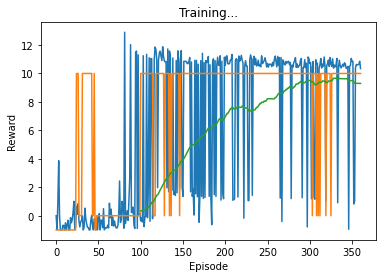

Episode 361 
 100 episode moving avg: 9.296137809753418 
 Epsilon: 1.0 



In [ ]:
#Parameters for visualization
visualize_training = False
visualize_q_values = False#not visualize_training
delay = 0.8

episode_rewards = []
episode_rewards_exploit=[] 

for episode in range(num_episodes):
    #visualize_training = True if episode%100==0 else False
    ep_reward = 0
    em.reset()
    state = em.get_state()
    

    if (visualize_training):
        em.render("image")
        em.render("human")
        plt.pause(delay)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action, memory)
        next_state = em.get_state()
        terminated = torch.tensor([em.done],dtype=torch.bool).to(device) 
        memory.push(Experience(state, action, next_state, reward, terminated))
        state = next_state
        ep_reward += reward.item()


        if (visualize_q_values):
            display_q_values()
            #if is_ipython: display.clear_output(wait=True)

        if (visualize_training):
            em.render("image")
            em.render("human")
            print("Episode: "+str(episode))
            print("Timestep: "+str(timestep))
            if(episode%10 == 0 and episode != 0 and timestep == 0):
                display_q_values()
                # input()
            plt.pause(delay)

        if (visualize_training or visualize_q_values):
            print(reward.item())

        
            

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states, terminated = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states, terminated)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()       
   
        
        if timestep > len(em.original_map):
            em.done = True
        
        if em.done:
            episode_rewards.append(ep_reward)
            eps = agent.strategy.get_exploration_rate(agent.current_step)
            
            #run an episode only exploiting
            episode_rewards_exploit.append(exploit_episode(policy_net))

            if(visualize_q_values == False):                
                plot(episode_rewards, 100, eps,episode_rewards_exploit)
            break
        
        if timestep % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())



    # import time    
    # time.sleep(1)
    # display.c lear_output(wait=True) 

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

        
em.close()

# Display Q-values


In [ ]:
display_q_values()

In [ ]:
plot(episode_rewards, 100, eps, episode_rewards_exploit)

# Test

In [ ]:
import time
#map_joan, map_frozen_lake = [3,3,3,3,3,1,3,1,3,3,3,1,1,3,3,0],MAPS['4x4']
#map_joan, map_frozen_lake = generate_random_map(size=4, p=random.uniform(0.1, 0.8)) 
#Environment manager
em = FrozenLakeEnvManager(device, map_joan, map_frozen_lake)

em.reset()
em.render("image")
plt.pause(0.3)
while(em.done == False):
    state = em.get_state()
    action = torch.tensor(policy_net(state).argmax(dim=1).to(device) ).to(device)
    print(action)
    reward = em.take_action(action,memory)
    next_state = em.get_state()
    state = next_state
    
    em.render("image")
    plt.pause(0.3)
    print(em.done)

In [ ]:
save = False

if(save):
    filename = str(int(np.sqrt(len(em.original_map))))
    if(SOFTMAX):
        filename = filename +"-SOFTMAX"
    if(EPSILON):
        filename = filename +"-EPSILON"
    if(COUNT):
        filename = filename +"-COUNT"

    import pickle
    pickle.dump([episode_rewards,episode_rewards_exploit], open(filename, "wb"))

    episode_rewards,episode_rewards_exploit = pickle.load(open(filename,"rb"))
    print(filename)
    plot(episode_rewards, 100, eps, episode_rewards_exploit)

Save model

In [ ]:
import time
model_save_name = "MODEL-"+filename
path = "C:/Users/joanp/OneDrive/Escritorio/TFG_RESULTS/models/"+model_save_name
if(save):
    torch.save(policy_net.state_dict(), path)


Load model

In [ ]:
load = False
model_name = "MODEL-6-SOFTMAX-COUNT"
model_path = "C:/Users/joanp/OneDrive/Escritorio/TFG_RESULTS/models/"+model_name
if(load):
    policy_net = DQN(1, em.num_actions_available()).to(device)
    policy_net.load_state_dict(torch.load(model_path))
    policy_net.eval()